- PDF in API
- Context caching
- Structured outputs

In [1]:
from google.generativeai import caching
import datetime
import time

In [2]:
from IPython.display import Image, display, Markdown
import google.generativeai as genai
import os
import keys
os.environ["GOOGLE_API_KEY"] = keys.gemini_api_key 
genai.configure(api_key= os.environ["GOOGLE_API_KEY"])

In [7]:
video_path = r"C:\Users\HP\Downloads\vid.mp4"
video_file = genai.upload_file(path= video_path)

### Video processing takes time for bigger videos

In [11]:
while video_file.state.name == "PROCESSING":
    print("Video is processing..")
    time.sleep(2)
    video_file = genai.get_file(video_file.name)
    
print(f"Processing done: {video_file.uri}")

Video is processing..
Processing done: https://generativelanguage.googleapis.com/v1beta/files/enyewycfx4f6


In [42]:
llm = genai.GenerativeModel(model_name= "models/gemini-1.5-flash-001")

In [44]:
%%time
resp = llm.generate_content([video_file, "Explain what happend in that video in this interval: 2:40 - 3:00"])

CPU times: total: 15.6 ms
Wall time: 8.29 s


In [45]:
Markdown(resp.text)

The Jade Palace is being destroyed by the powerful chi being used by Tai Lung.  Shifu is trapped on the top of the palace and as the whole thing crumbles, he is seen flying through the air as the palace falls to pieces. 

In [46]:
resp.usage_metadata

prompt_token_count: 81443
candidates_token_count: 49
total_token_count: 81492

## cache the video

In [32]:
cache = caching.CachedContent.create(
    model="models/gemini-1.5-flash-001",
    display_name="kfp-video-clip-kai-destroys-jade-palace", # used to identify the cache
    system_instruction= "You are an expert video analyszer, and your job is to answer user's query based on the video file you have access to.",
    contents=[video_file],
    ttl= datetime.timedelta(minutes=10) # how long should the cache stay?
)

In [33]:
cache.expire_time

DatetimeWithNanoseconds(2024, 9, 25, 13, 3, 57, 731322, tzinfo=datetime.timezone.utc)

In [36]:
%%time

model= genai.GenerativeModel.from_cached_content(cached_content=cache)
response = model.generate_content(["Explain what happend in that video in this interval: 2:40 - 3:00."])

CPU times: total: 0 ns
Wall time: 8.41 s


In [38]:
Markdown(response.text)

The bull, Tai Lung, is using his chain-weapons to launch a large boulder at the Jade Palace. The boulder comes flying toward the palace, shattering the side of the building, as the Furious Five try to get out of the way. 


In [40]:
response.usage_metadata

prompt_token_count: 81473
cached_content_token_count: 81449
candidates_token_count: 49
total_token_count: 81522

In [50]:
cache.expire_time

DatetimeWithNanoseconds(2024, 9, 25, 13, 3, 57, 731322, tzinfo=datetime.timezone.utc)

## Cache expires at 13:03:57 UTC

In [62]:
current_time = datetime.datetime.now(datetime.timezone.utc)  # Convert to local time if needed
print(current_time)

2024-09-25 13:12:17.179457+00:00


In [72]:
from google.api_core.exceptions import PermissionDenied
try:
    response = model.generate_content(["Explain what happend in that video in this interval: 2:40 - 3:00."])

except PermissionDenied as e:
    print(f"Cache Expired: {e}")
    pass

Cache Expired: 403 CachedContent not found (or permission denied)


## interact with PDF

In [6]:
def upload_file_to_gemini(path, mime_type=None):
    file = genai.upload_file(path, mime_type=mime_type)
    print(f"file {file.display_name} uploaded as: {file.uri}")
    return file

def wait_for_files_to_be_active(files):
    for name in (file.name for file in files):
        file = genai.get_file(name)
        while file.state.name == "PROCESSING":
            print(".", end="", flush=True)
            time.sleep(10)
            file = genai.get_file(name)
        if file.state.name != "ACTIVE":
            raise Exception(f"File {file.name} failed to process")
    print("...all files are ready")

In [8]:
gen_config= {
    "temperature": 0,
    "response_mime_type": "text/plain",
    "top_p": 0.95,
    "top_k": 64,
    "max_output_tokens": 8192
}

In [18]:
model = genai.GenerativeModel(
    model_name="gemini-1.5-pro",
    generation_config=gen_config
)

files = [
    upload_file_to_gemini(r"C:/Users/HP/Desktop/test-pdf.pdf", mime_type="application/pdf")
]

wait_for_files_to_be_active(files)
chat_session = model.start_chat(
    history=[
        {
            "role": "user",
            "parts": [
                files[0],
                "How many pages are there in the pdf?"
            ]
        }
    ]
)

file test-pdf.pdf uploaded as: https://generativelanguage.googleapis.com/v1beta/files/tam29i0fhpej
...all files are ready


In [24]:
response = chat_session.send_message("Extract all the text")

In [32]:
response.usage_metadata

prompt_token_count: 3720
candidates_token_count: 2040
total_token_count: 5760

## Gemini Structured Outputs

In [40]:
import json
import dataclasses
import typing_extensions as typing

In [50]:
model= genai.GenerativeModel(
    "gemini-1.5-flash",
    generation_config= {
        "response_mime_type": "application/json"
    }
)

prompt = """
List 5 popular types of cakes using this JSON Schema:
Recipe= {'cake_id': str, 'cake_name': str}, where cake_id is the S.no starting with '001', 'cake_name' is the name of the cake

Return a 'List[Recipe]'
"""

response = model.generate_content(prompt)
print(response.text)

[{"cake_id": "001", "cake_name": "Chocolate Cake"}, {"cake_id": "002", "cake_name": "Vanilla Cake"}, {"cake_id": "003", "cake_name": "Red Velvet Cake"}, {"cake_id": "004", "cake_name": "Cheesecake"}, {"cake_id": "005", "cake_name": "Carrot Cake"}]



In [52]:
type(response.text)

str

In [58]:
class Recipe(typing.TypedDict):
    cake_id: str
    cake_name: str

model= genai.GenerativeModel(
    "gemini-1.5-flash",
    generation_config= {
        "response_mime_type": "application/json",
        "response_schema": list[Recipe]
    }
)

prompt = "List 5 popular types of cakes, include cake_ids starting with 001"
response = model.generate_content(prompt)
print(response.text)

[{"cake_id": "001", "cake_name": "Chocolate Cake"}, {"cake_id": "002", "cake_name": "Vanilla Cake"}, {"cake_id": "003", "cake_name": "Red Velvet Cake"}, {"cake_id": "004", "cake_name": "Cheesecake"}, {"cake_id": "005", "cake_name": "Carrot Cake"}] 


In [61]:
type(response.text)

str

#### Convert to Pydantic classes

In [77]:
from pydantic import BaseModel
from typing import List
import json

class Recipe(BaseModel):
    """
    Represents a type of cake.
    """
    cake_id: str
    cake_name: str

class RecipeList(BaseModel):
    """
    Represents a list of cakes.
    """
    recipes: List[Recipe]

data= json.loads(response.text)

recipe_list = RecipeList(recipes= [Recipe(**recipe) for recipe in data])

In [79]:
recipe_list.recipes

[Recipe(cake_id='001', cake_name='Chocolate Cake'),
 Recipe(cake_id='002', cake_name='Vanilla Cake'),
 Recipe(cake_id='003', cake_name='Red Velvet Cake'),
 Recipe(cake_id='004', cake_name='Cheesecake'),
 Recipe(cake_id='005', cake_name='Carrot Cake')]

In [81]:
json_schema = RecipeList.schema_json(indent=2)
print(json_schema)

{
  "$defs": {
    "Recipe": {
      "description": "Represents a type of cake.",
      "properties": {
        "cake_id": {
          "title": "Cake Id",
          "type": "string"
        },
        "cake_name": {
          "title": "Cake Name",
          "type": "string"
        }
      },
      "required": [
        "cake_id",
        "cake_name"
      ],
      "title": "Recipe",
      "type": "object"
    }
  },
  "description": "Represents a list of cakes.",
  "properties": {
    "recipes": {
      "items": {
        "$ref": "#/$defs/Recipe"
      },
      "title": "Recipes",
      "type": "array"
    }
  },
  "required": [
    "recipes"
  ],
  "title": "RecipeList",
  "type": "object"
}


In [99]:
url= "https://nfcihospitality.com/popular-cake-flavour-in-india/"

In [101]:
import newspaper

def download_article(url):
    article = newspaper.Article(url)
    article.download()
    article.parse()

    article_text = article.text

    return article_text

article = download_article(url)
print("Article content:")
print(f"{article[:500]}...")

Article content:
Introduction

Cakes in India has not come out of our historical food and dishes but it is a western culture dessert that we have adopted. Cake flavour are always changing around the world with new innovative ideas, with cake flavour, designs, decorations, season, shapes and textures.

We all have our personal favourite’s flavours when it comes to cakes, one factor is common us all – we all love cake, no matter our age! Kids, old, and young age doesn’t matter.

Every event like birthday, annivers...


In [111]:
model = genai.GenerativeModel(
    "models/gemini-1.5-flash",
    system_instruction= f"""You are a helpful assisstant that scans for cakes mentioned in articles.
    Use this JSON schema, include cake_id starting with 001:
    RecipeList = {json_schema}""",
    generation_config= {
        "response_mime_type": "application/json",
        "response_schema": RecipeList
    }
)

In [113]:
response= model.generate_content(article)

In [115]:
response.text

'{"recipes": [{"cake_id": "001", "cake_name": "Chocolate Cake"}, {"cake_id": "002", "cake_name": "Vanilla Cake"}, {"cake_id": "003", "cake_name": "Strawberry Cake"}, {"cake_id": "004", "cake_name": "Butterscotch Cake"}, {"cake_id": "005", "cake_name": "Red Velvet Cake"}, {"cake_id": "006", "cake_name": "Fruit Cake"}, {"cake_id": "007", "cake_name": "Pineapple Cake"}, {"cake_id": "008", "cake_name": "Rasmalai Cake"}, {"cake_id": "009", "cake_name": "Cheese Cake"}, {"cake_id": "010", "cake_name": "Kit Kat Cake"}, {"cake_id": "011", "cake_name": "Blueberry Cake"}, {"cake_id": "012", "cake_name": "Mango Cake"}, {"cake_id": "013", "cake_name": "Coffee Cake"}, {"cake_id": "014", "cake_name": "Black Forest Cake"}, {"cake_id": "015", "cake_name": "Ferrero Rocher Cake"}, {"cake_id": "016", "cake_name": "Caramel Cake"}, {"cake_id": "017", "cake_name": "Lemon Cake"}, {"cake_id": "018", "cake_name": "Carrot Cake"}, {"cake_id": "019", "cake_name": "Coconut Cake"}]} '

In [121]:
json_object = json.loads(response.text)
json_object

{'recipes': [{'cake_id': '001', 'cake_name': 'Chocolate Cake'},
  {'cake_id': '002', 'cake_name': 'Vanilla Cake'},
  {'cake_id': '003', 'cake_name': 'Strawberry Cake'},
  {'cake_id': '004', 'cake_name': 'Butterscotch Cake'},
  {'cake_id': '005', 'cake_name': 'Red Velvet Cake'},
  {'cake_id': '006', 'cake_name': 'Fruit Cake'},
  {'cake_id': '007', 'cake_name': 'Pineapple Cake'},
  {'cake_id': '008', 'cake_name': 'Rasmalai Cake'},
  {'cake_id': '009', 'cake_name': 'Cheese Cake'},
  {'cake_id': '010', 'cake_name': 'Kit Kat Cake'},
  {'cake_id': '011', 'cake_name': 'Blueberry Cake'},
  {'cake_id': '012', 'cake_name': 'Mango Cake'},
  {'cake_id': '013', 'cake_name': 'Coffee Cake'},
  {'cake_id': '014', 'cake_name': 'Black Forest Cake'},
  {'cake_id': '015', 'cake_name': 'Ferrero Rocher Cake'},
  {'cake_id': '016', 'cake_name': 'Caramel Cake'},
  {'cake_id': '017', 'cake_name': 'Lemon Cake'},
  {'cake_id': '018', 'cake_name': 'Carrot Cake'},
  {'cake_id': '019', 'cake_name': 'Coconut Cake'}]

In [123]:
type(json_object)

dict

In [125]:
data= [Recipe(cake_id=x["cake_id"], cake_name=x["cake_name"]) for x in json_object["recipes"]]

In [129]:
data = RecipeList(recipes=data)

In [131]:
data

RecipeList(recipes=[Recipe(cake_id='001', cake_name='Chocolate Cake'), Recipe(cake_id='002', cake_name='Vanilla Cake'), Recipe(cake_id='003', cake_name='Strawberry Cake'), Recipe(cake_id='004', cake_name='Butterscotch Cake'), Recipe(cake_id='005', cake_name='Red Velvet Cake'), Recipe(cake_id='006', cake_name='Fruit Cake'), Recipe(cake_id='007', cake_name='Pineapple Cake'), Recipe(cake_id='008', cake_name='Rasmalai Cake'), Recipe(cake_id='009', cake_name='Cheese Cake'), Recipe(cake_id='010', cake_name='Kit Kat Cake'), Recipe(cake_id='011', cake_name='Blueberry Cake'), Recipe(cake_id='012', cake_name='Mango Cake'), Recipe(cake_id='013', cake_name='Coffee Cake'), Recipe(cake_id='014', cake_name='Black Forest Cake'), Recipe(cake_id='015', cake_name='Ferrero Rocher Cake'), Recipe(cake_id='016', cake_name='Caramel Cake'), Recipe(cake_id='017', cake_name='Lemon Cake'), Recipe(cake_id='018', cake_name='Carrot Cake'), Recipe(cake_id='019', cake_name='Coconut Cake')])

In [139]:
data.recipes[0]

Recipe(cake_id='001', cake_name='Chocolate Cake')

#### Structured outputs from images

In [142]:
image_path= r"C:\Users\HP\Downloads\infoboard.png"
from PIL import Image
img= Image.open(image_path)

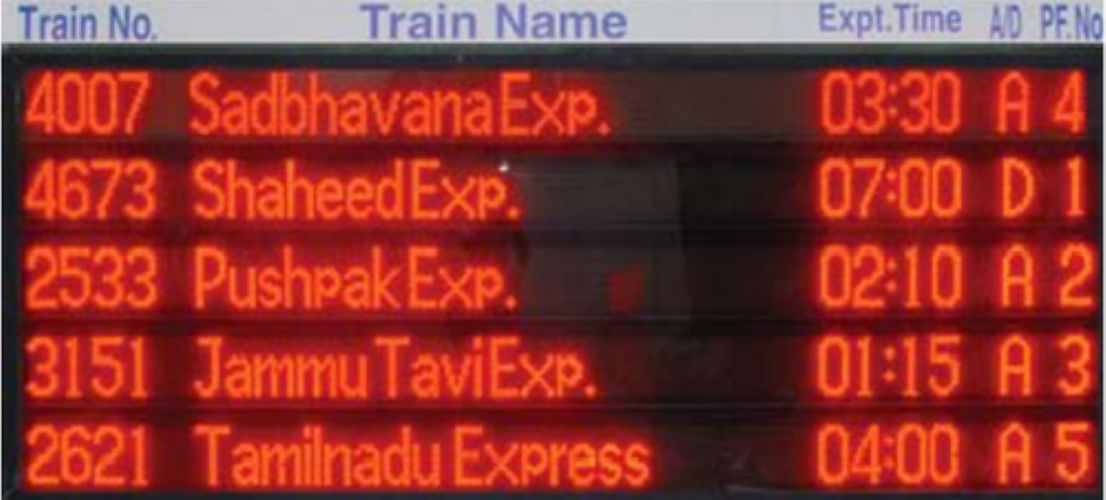

In [144]:
img

In [176]:
class RailwayData(BaseModel):
    """
    Represents Train's information about arrival
    """
    train_no: int
    train_name: str
    train_expt_time: str
    train_status: str
    platform_number: int

model = genai.GenerativeModel(
    "gemini-1.5-pro",
    generation_config= {
        "response_mime_type": "application/json",
        "response_schema": list[RailwayData]
    }
)

prompt = "List out the train information from the image"

response = model.generate_content([prompt, img])

In [226]:
obj = json.loads(response.text)

In [238]:
df = pd.DataFrame(obj)
columns = ["train_no", "train_name", "train_expt_time", "platform_number"]
df[columns]

,train_no,train_name,train_expt_time,platform_number
0,4007,Sadbhavana Exp.,03:30,4
1,4673,Shaheed Exp.,07:00,1
2,2533,Pushpak Exp.,02:10,2
3,3151,Jammu Tavi Exp.,01:15,3
4,2621,Tamilnadu Express,04:00,5
